In [1]:
!unzip glove.6B.zip -d my_data


unzip:  cannot find or open glove.6B.zip, glove.6B.zip.zip or glove.6B.zip.ZIP.


In [2]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import tensorflow as tf
import keras
from keras.layers import Dense, Embedding, Input, Flatten, LSTM, Conv1D, concatenate, MaxPooling1D
from keras.models import Sequential, Model
from keras_preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB


In [5]:
max_len = 50
embedding_dim = 100

In [7]:
sns.set_theme(style="whitegrid")
train = pd.read_csv("augmented_train.csv")
test = pd.read_csv("test.csv")

Text(0.5, 0, 'Labels')

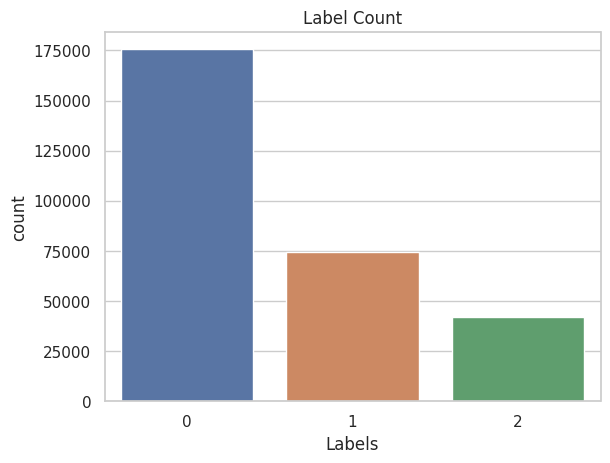

In [8]:
sns.countplot(x=train['label'])
plt.title("Label Count")
plt.xlabel("Labels")

In [9]:
train['label'].value_counts()

0    175598
1     74238
2     42146
Name: label, dtype: int64

In [10]:
train.head()

,Unnamed: 0,title1_en,title2_en,label
0,1383,It turns out Ma Huateng ' second daughter Ma M...,Ma Huateng tells the rumour that Wang Zhong pu...,2
1,117507,Netflix fly-by-plane fly-in-the-mud-moths-Urum...,- Texas Airplanes for Moths? - MLA: Rumors.,0
2,156419,Women on the subway do not give a seat to the ...,"A man gives a seat to a pregnant woman, and a ...",0
3,239056,"A magic grass, cure uncle's diabetes mellitus!",You know what? Here comes Diabetic Friendship....,1
4,192827,The photographer adventured to explore Fan Che...,New traffic rules are to be implemented from N...,0


In [11]:
train['label'].value_counts()

0    175598
1     74238
2     42146
Name: label, dtype: int64

In [12]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.0 MB/s eta 0:00:00


In [13]:
from transformers import AutoTokenizer

In [14]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
# tokens = tokenizer.encode_plus("hello world", max_length=max_len, truncation=True, padding="max_length", return_token_type_ids=False, return_attention_mask=True, return_tensors='tf')

In [15]:
Xids1 = np.zeros((len(train), max_len))
Xmask1 = np.zeros((len(train), max_len))
Xids2 = np.zeros((len(train), max_len))
Xmask2 = np.zeros((len(train), max_len))


In [16]:
for i, sequence in enumerate(train['title1_en']):
  tokens =  tokenizer.encode_plus(sequence, max_length=max_len, truncation=True, padding="max_length", return_token_type_ids=False, return_attention_mask=True, return_tensors='tf')
  Xids1[i, :], Xmask1[i,:] = tokens['input_ids'], tokens['attention_mask']


for i, sequence in enumerate(train['title2_en']):
  tokens =  tokenizer.encode_plus(sequence, max_length=max_len, truncation=True, padding="max_length", return_token_type_ids=False, return_attention_mask=True, return_tensors='tf')
  Xids2[i, :], Xmask2[i,:] = tokens['input_ids'], tokens['attention_mask']


In [17]:
Xids1

array([[  101.,  1135.,  3587., ...,     0.,     0.,     0.],
       [  101., 22989.,  4689., ...,     0.,     0.,     0.],
       [  101.,  2453.,  1113., ...,     0.,     0.,     0.],
       ...,
       [  101.,  1203.,  1214., ...,     0.,     0.,     0.],
       [  101.,  5370., 26888., ...,     0.,     0.,     0.],
       [  101.,  3957.,  1105., ...,     0.,     0.,     0.]])

In [18]:
Xmask1

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [19]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [20]:
dataset = tf.data.Dataset.from_tensor_slices((Xids1, Xmask1, Xids2, Xmask2, train['label']))

In [21]:
def map_func(input_ids1, masks1, input_ids2, masks2, labels):
  return {'input_ids1':input_ids1, 'masks1': masks1, 'input_ids2': input_ids2, 'masks2':masks2}, labels

In [22]:
dataset = dataset.map(map_func)

In [23]:
for i in dataset.take(1):
  print(i)

({'input_ids1': <tf.Tensor: shape=(50,), dtype=float64, numpy=
array([  101.,  1135.,  3587.,  1149.,  7085., 20164.,  2193.,  2118.,
         112.,  1248.,  1797.,  7085.,  2268.,   118.,   181.,  1394.,
        1110.,  1177.,  2712.,   117.,  1185.,  4608.,  1115.,  7014.,
       14159.,   118., 14255.,  1403.,  3349.,  1106.,  9839.,  1122.,
         106.,   102.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.])>, 'masks1': <tf.Tensor: shape=(50,), dtype=float64, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])>, 'input_ids2': <tf.Tensor: shape=(50,), dtype=float64, numpy=
array([  101.,  7085., 20164.,  2193.,  2118.,  3301.,  1103.,   187.,
       27226.,  1115.,  7014.,   163., 15564.,  9281.,  1117.,  1797.,
 

In [24]:
dataset = dataset.shuffle(1).batch(128)

In [25]:
DS_LEN = len(list(dataset))

In [26]:
print(DS_LEN), len(train) // 128

2282


(None, 2281)

In [27]:
from transformers import TFAutoModel
bert = TFAutoModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [28]:
input_shape = (max_len,)
input_ids1 = tf.keras.layers.Input(shape=input_shape, name='input_ids1', dtype='int32')
masks1 = tf.keras.layers.Input(shape=input_shape, name='masks1', dtype='int32')
input_ids2 = tf.keras.layers.Input(shape=input_shape, name='input_ids2', dtype='int32')
masks2 = tf.keras.layers.Input(shape=input_shape, name='masks2', dtype='int32')



In [29]:
embeddings1 = bert(input_ids1, attention_mask=masks1)[0]
embeddings2 = bert(input_ids2, attention_mask=masks2)[0]

In [30]:
conv1 = Conv1D(128, 3, activation='relu')(embeddings1)
conv2 = Conv1D(128, 3, activation='relu')(embeddings2)

pool1 = MaxPooling1D()(conv1)
pool2 = MaxPooling1D()(conv2)

lstm1 = LSTM(64)(pool1)
lstm2 = LSTM(64)(pool2)

x1 = Dense(32)(lstm1)
x2 = Dense(32)(lstm2)

conc = concatenate([x1, x2], axis=-1)
x = Dense(16, activation='relu')(conc)

y = Dense(3, activation='softmax')(x)


model = Model([input_ids1, masks1, input_ids2, masks2], y)
model.layers[4].trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids1 (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 masks1 (InputLayer)            [(None, 50)]         0           []                               
                                                                                                  
 input_ids2 (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 masks2 (InputLayer)            [(None, 50)]         0           []                               
                                                                                              

In [31]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Nadam(learning_rate=0.00075), metrics=['accuracy']) 
history = model.fit(dataset, epochs=6)

Epoch 1/6
2282/2282 [==============================] - 1987s 851ms/step - loss: 0.5944 - accuracy: 0.6994
Epoch 2/6
2282/2282 [==============================] - 1943s 851ms/step - loss: 0.4792 - accuracy: 0.7615
Epoch 3/6
2282/2282 [==============================] - 1941s 851ms/step - loss: 0.4204 - accuracy: 0.7946
Epoch 4/6
2282/2282 [==============================] - 1941s 851ms/step - loss: 0.3816 - accuracy: 0.8172
Epoch 5/6
2282/2282 [==============================] - 1938s 849ms/step - loss: 0.3544 - accuracy: 0.8335
Epoch 6/6
2282/2282 [==============================] - 1939s 850ms/step - loss: 0.3333 - accuracy: 0.8459


In [32]:
model.save_weights("BERT_Final.h5")